In [1]:
%matplotlib inline

import fipy as fp
from fipy.tools.dump import read
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as p
from fvm_utils import *
import torch

print(torch.cuda.is_available())

True


# Hybrid parameter estimation: linear regression and neural networks

Inspired by some scribbles on a Zoom whiteboard with Danny Seara, see below

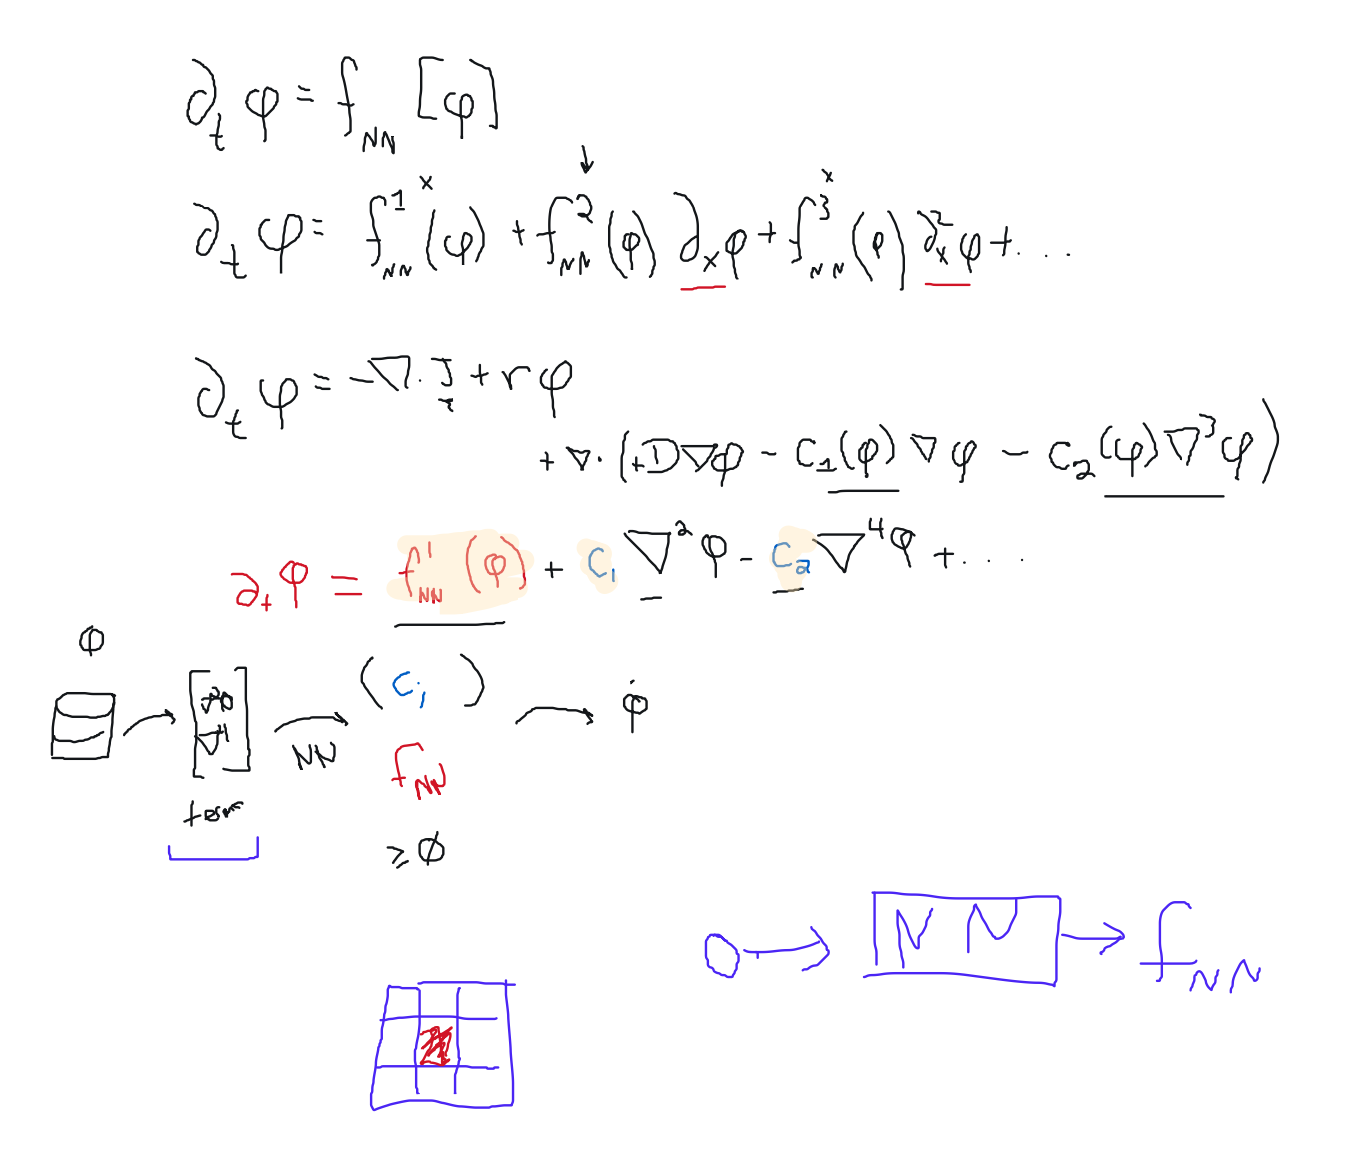

270


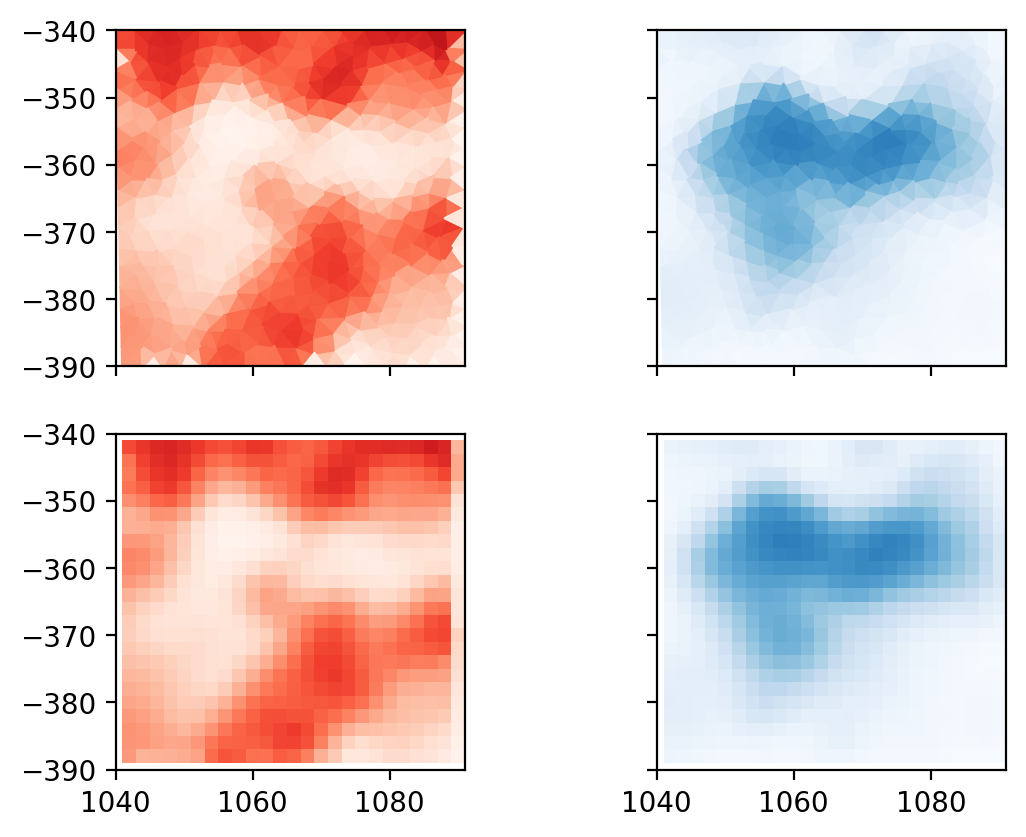

In [46]:
import os
from glob import glob
from fipy.tools.dump import read
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose

from fvm_utils import calc_gradients
from scipy.interpolate import griddata

class ComputeGradients:
    """ Compute and return the sociohydrodynamic gradients """
    def __init__(self, gradients='sociohydro'):
        """ gradients = ['sociohydro', 'all'] specifies which grouping to use """
        self.gradients = gradients

    def __call__(self, sample):
        all_gradients, sociohydro_gradients = calc_gradients(sample['W0'], sample['B0'])
        if self.gradients == 'all':
            sample['gradients'] = [all_gradients, all_gradients]
        elif self.gradients == 'sociohydro':
            sample['gradients'] = sociohydro_gradients
        
        return sample

class InterpolateToGrid:
    """ Interpolate ϕW, ϕB to a regular grid using scipy.interpolate.griddata """
    def __init__(self, method='nearest', d=2.):
        self.method = method
        self.d = d
    
    def interpolate_fipy(self, data, X, Y):
        # Get boundaries of each triangular cell
        vertices = data.mesh.vertexCoords[:, data.mesh._orderedCellVertexIDs]
        # Get centroids
        centroids = np.mean(vertices, axis=1).T
        # Interpolate
        return griddata(centroids, data, (X, Y))

    def __call__(self, sample):
        # Establish common target coordinate system
        mesh = sample['W0'].mesh
        xmin, ymin = mesh.extents['min']
        xmax, ymax = mesh.extents['max']
        xx = np.arange(xmin, xmax+self.d, self.d)
        yy = np.arange(ymin, ymax+self.d, self.d)
        X, Y = np.meshgrid(xx, yy)

        sample['X'] = X
        sample['Y'] = Y

        # Initial point
        sample['W0_grid'] = self.interpolate_fipy(sample['W0'], X, Y)
        sample['B0_grid'] = self.interpolate_fipy(sample['B0'], X, Y)

        # End point
        sample['W1_grid'] = self.interpolate_fipy(sample['W1'], X, Y)
        sample['B1_grid'] = self.interpolate_fipy(sample['B1'], X, Y)

        # Interpolate and stack gradients
        gradients_grid = [
            [self.interpolate_fipy(grad, X, Y) for grad in sample['gradients'][0]],
            [self.interpolate_fipy(grad, X, Y) for grad in sample['gradients'][1]]
        ]
        sample['gradients_grid'] = np.asarray(gradients_grid)

        return sample


class ComputeDerivative:
    """ Compute the discrete time derivative using forward differences """
    def __call__(self, sample):
        sample['dt_W'] = (sample['W1_grid'] - sample['W0_grid']) / (sample['t1'] - sample['t0'])
        sample['dt_B'] = (sample['B1_grid'] - sample['B0_grid']) / (sample['t1'] - sample['t0'])
        return sample

class ToTensor:
    """ Compute numpy objects into torch tensors """
    def __call__(self, sample):
        for key in sample:
            if isinstance(sample[key], np.ndarray):
                #print(f'Converting {key} to torch FloatTensor with shape {sample[key].shape}')
                sample[key] = torch.FloatTensor(sample[key])
        
        return sample


class FipyDataset(Dataset):
    """ Dataset that loads and transforms data from fipy """
    def __init__(self, path="./data/Georgia_Fulton_small/fipy_output"):
        self.files = sorted(glob(os.path.join(path, "*.fipy")))
        self.transform = Compose([
            ComputeGradients(),
            InterpolateToGrid(),
            ComputeDerivative(),
            ToTensor(),
        ])
    
    def __len__(self):
        return len(self.files) - 1

    def __getitem__(self, idx):
        W0, B0, t0 = read(self.files[idx])
        W1, B1, t1 = read(self.files[idx+1])

        sample = {
            'W0': W0,
            'B0': B0,
            'W1': W1,
            'B1': B1,
            't0': t0,
            't1': t1
        }

        sample = self.transform(sample)
        return sample


dataset = FipyDataset()
print(len(dataset))
sample = dataset[5]

# Plot everything to make sure that things look correct
from fvm_utils import plot_mesh
fig, ax = plt.subplots(2, 2, dpi=200, sharex=True, sharey=True)

# Plot original fipy objects
plot_mesh(sample['W0'], sample['W0'].mesh, ax[0, 0], cmap=plt.cm.Reds, vmin=0, vmax=1)
plot_mesh(sample['B0'], sample['B0'].mesh, ax[0, 1], cmap=plt.cm.Blues, vmin=0, vmax=1)

# Plot 
ax[1, 0].pcolormesh(sample['X'], sample['Y'], sample['W0_grid'], cmap='Reds', vmin=0, vmax=1)
ax[1, 1].pcolormesh(sample['X'], sample['Y'], sample['B0_grid'], cmap='Blues', vmin=0, vmax=1)

for a in ax.flatten():
    a.set_aspect(np.ptp(a.get_ylim()) / np.ptp(a.get_xlim()))